In [68]:
#importações necessárias para manipulação e visualização dos dados 
import re
import pandas as pd
import numpy as np
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt 

#importação para pré-processamento e ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib



In [69]:
#configuração de visualização
sns.set_style('whitegrid')

In [70]:
#carregando os dados 
df_emocoes_csv0 = 'dataset.csv'
df_emocoes_csv0 = pd.read_csv(df_emocoes_csv0)

In [71]:
#primeiras linhas
df_emocoes_csv0.head(10)

,review_id,texto_review,sentimento
0,1,Estou muito feliz com a compra. O cadeira game...,positivo
1,2,NaN,negativo
2,3,Não recomendo. A entrega foi lenta e o celular...,negativo
3,4,O monitor é decepcionante. O suporte ao client...,positivo
4,5,É UM LIVRO OK PELO PRÇEO QUE PAGUEI.,negativo
5,6,Não rceomendo. A entrega atrasou muito e o mon...,positivo
6,7,Péssima experiência. O livro quebrou no primei...,negativo
7,8,Recebi o fone de ouvido hoje. Vou começar a us...,positivo
8,9,Estou muito arrependido com esta compra. Dinhe...,negativo
9,10,Ótimo custo-benefício. O celular é excelente e...,positivo


In [72]:
#buscando dados ausentes 
df_emocoes_csv0.isnull().sum()

review_id        0
texto_review    12
sentimento       0
dtype: int64

verificando distribuição dos sentimentos


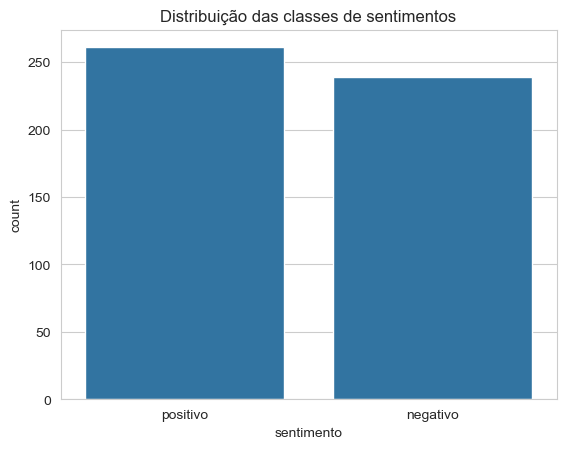

In [73]:
print('verificando distribuição dos sentimentos')
sns.countplot(x = 'sentimento', data=df_emocoes_csv0)
plt.title('Distribuição das classes de sentimentos')
plt.show()

In [74]:
#verificando tamanho do data antes da limpeza
len(df_emocoes_csv0)

500

In [75]:
#removendo dados ausentes
df_emocoes_csv1 = df_emocoes_csv0.dropna(subset =['texto_review'])

In [76]:
#tamanho do data depois da limpeza
len(df_emocoes_csv1)

488

In [87]:
#fazendo uma função para limpar o texto
def limpeza_do_texto (texto):
#garantindo que o texto não esteja vazio/nulo
    if not isinstance(texto, str):
        return ""
    
    #separa o caractere de acentuação e depois remove os acentos
    texto_sem_acento = ''.join(c for c in unicodedata.normalize('NFKD', texto) if unicodedata.category(c) != 'Mn') 

    #convertendo para minúsculo
    texto_limpo = texto_sem_acento.lower()

    #mantendo apenas letras e espaços
    texto_limpo = re.sub(r'[^a-z\s]', '', texto_limpo)

    #removendo espaços extras
    texto_limpo = re.sub(r'\s+', ' ', texto_limpo).strip()

    return texto_limpo



In [88]:
#aplicando a função limpeza
df_emocoes_csv1['texto_limpo'] = df_emocoes_csv1['texto_review'].apply(limpeza_do_texto)

KeyError: 'texto_review'

In [82]:
df_emocoes_csv1.head()

,review_id,texto_review,sentimento,texto_limpo
0,1,Estou muito feliz com a compra. O cadeira game...,positivo,estou muito feliz com a compra o cadeira gamer...
2,3,Não recomendo. A entrega foi lenta e o celular...,negativo,nao recomendo a entrega foi lenta e o celular ...
3,4,O monitor é decepcionante. O suporte ao client...,positivo,o monitor e decepcionante o suporte ao cliente...
4,5,É UM LIVRO OK PELO PRÇEO QUE PAGUEI.,negativo,e um livro ok pelo prceo que paguei
5,6,Não rceomendo. A entrega atrasou muito e o mon...,positivo,nao rceomendo a entrega atrasou muito e o moni...


In [83]:
df_emocoes_csv1 = df_emocoes_csv1.drop(columns=['texto_review'])

In [84]:
df_emocoes_csv1.head()

,review_id,sentimento,texto_limpo
0,1,positivo,estou muito feliz com a compra o cadeira gamer...
2,3,negativo,nao recomendo a entrega foi lenta e o celular ...
3,4,positivo,o monitor e decepcionante o suporte ao cliente...
4,5,negativo,e um livro ok pelo prceo que paguei
5,6,positivo,nao rceomendo a entrega atrasou muito e o moni...


In [89]:
#mapeando sentimentos para valores númericos 
df_emocoes_csv1 ['sentimentos_label'] = df_emocoes_csv1['sentimento'].map({'positivo':1,'negativo':0})

In [90]:
print("\nDataframe após a limpeza e mapeamento:\n")
df_emocoes_csv1.head()


Dataframe após a limpeza e mapeamento:



,review_id,sentimento,texto_limpo,sentimentos_label
0,1,positivo,estou muito feliz com a compra o cadeira gamer...,1
2,3,negativo,nao recomendo a entrega foi lenta e o celular ...,0
3,4,positivo,o monitor e decepcionante o suporte ao cliente...,1
4,5,negativo,e um livro ok pelo prceo que paguei,0
5,6,positivo,nao rceomendo a entrega atrasou muito e o moni...,1


In [91]:
#divisão entre X (entrada) e Y (saída)

x = df_emocoes_csv1['texto_limpo']
y = df_emocoes_csv1['sentimentos_label']



In [92]:
#divisão de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.25, random_state=42, stratify= y)

In [99]:
#pipeline
pipeline = Pipeline([
  
  ('tfidf', TfidfVectorizer(stop_words= ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'que'])),
  ('scaler', StandardScaler(with_mean= False)),
  ('logreg', LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)) 

])

In [100]:
#otimização de hiperparâmetros

#definindo o grid dos hiper´s

paramentros_grid={
    'tfidf__max_features': [500,1000,2000],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'logreg__C': [0.1,1,10],
    'logreg__penalty':['l1','l2'],
    'logreg__max_iter':[5000,6000]
}

In [101]:
grid_search = GridSearchCV(
    pipeline, 
    paramentros_grid,
    cv= 5,
    n_jobs= -1,
    scoring= "accuracy",
    verbose=1
)

In [102]:
#treinamento
grid_search.fit(x_treino,y_treino)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\allla\anaconda3\envs\01\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\allla\anaconda3\envs\01\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...liblinear'))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'logreg__C': [0.1, 1, ...], 'logreg__max_iter': [5000, 6000], 'logreg__penalty': ['l1', 'l2'], 'tfidf__max_features': [500, 1000, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for

In [103]:
print('\nMelhores hiperparâmetros encontrados:\n')
print(grid_search.best_params_)


Melhores hiperparâmetros encontrados:

{'logreg__C': 0.1, 'logreg__max_iter': 5000, 'logreg__penalty': 'l1', 'tfidf__max_features': 500, 'tfidf__ngram_range': (1, 1)}


In [106]:
melhor_modelo = grid_search.best_estimator_
print(melhor_modelo)
type(melhor_modelo)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500,
                                 stop_words=['de', 'a', 'o', 'que', 'e', 'do',
                                             'da', 'em', 'que'])),
                ('scaler', StandardScaler(with_mean=False)),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=5000, penalty='l1',
                                    random_state=42, solver='liblinear'))])


sklearn.pipeline.Pipeline

In [109]:
#avaliando o modelo 
y_pred = melhor_modelo.predict(x_teste)

#calculando nas métricas
accuracy = accuracy_score(y_teste, y_pred)
report = classification_report(y_teste,y_pred, target_names=['negativo', 'positivo'])

In [111]:
print(f"\nAcurácia do modelo: {accuracy:.2%}\n")
print("Relatório de Classificação:\n")
print(report)


Acurácia do modelo: 81.15%

Relatório de Classificação:

              precision    recall  f1-score   support

    negativo       0.80      0.81      0.80        58
    positivo       0.83      0.81      0.82        64

    accuracy                           0.81       122
   macro avg       0.81      0.81      0.81       122
weighted avg       0.81      0.81      0.81       122



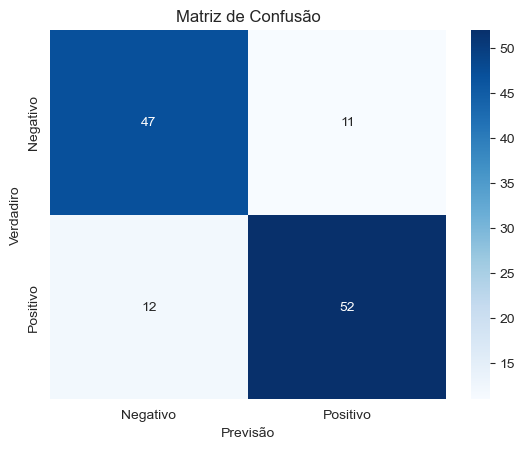

In [113]:
cm = confusion_matrix(y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap = "Blues",
        xticklabels=['Negativo', 'Positivo'],
        yticklabels=['Negativo', 'Positivo'])

plt.xlabel("Previsão")
plt.ylabel("Verdadiro")
plt.title("Matriz de Confusão")
plt.show()


In [115]:
#salvando modelo
joblib.dump(melhor_modelo,'melhor_modelo.joblid')

['melhor_modelo.joblid']

In [118]:
del melhor_modelo

In [119]:
#usando modelo salvo 
modelo_deploy = joblib.load('melhor_modelo.joblid')

In [120]:
type(modelo_deploy)

sklearn.pipeline.Pipeline

In [123]:
novos_reviews = [
    "A bateria do celular não dura nada, péssima compra",
    "Chegou rapido, melhor compra que já fiz",
    "Muito legal o ambiente, o atendimento é otímo",
    "não recomendo, o produto veio quebrado",
]

In [124]:
#função para classificar os novos reviews
def prever_sentimentos(reviews):
    previsoes = modelo_deploy.predict(reviews)

    #mapeia o resultado numérica de volta para texto
    sentimentos = ['Negativo' if p == 0 else 'Positivo' for p in previsoes]

    #resultados
    for  review, sentimentos, in zip(reviews, sentimentos):
        print(f"\nReview: '{review}'\n Sentimento previsto: {sentimentos}\n---")



In [125]:
prever_sentimentos(novos_reviews)


Review: 'A bateria do celular não dura nada, péssima compra'
 Sentimento previsto: Negativo
---

Review: 'Chegou rapido, melhor compra que já fiz'
 Sentimento previsto: Positivo
---

Review: 'Muito legal o ambiente, o atendimento é otímo'
 Sentimento previsto: Positivo
---

Review: 'não recomendo, o produto veio quebrado'
 Sentimento previsto: Negativo
---
